In [ ]:
#TODO: FIGURE OUT WHY MORE SCHOOLS ARE SHOWING UP 
import helper_functions as hf

In [2]:
hf.summary_table

,disciplinary_action_ratio,violent_incidents_ratio
count,18781.000,15650.000
mean,0.053,0.589
std,0.071,0.578
min,0.000,0.000
25%,0.006,0.125
50%,0.029,0.500
75%,0.072,0.933
max,0.767,6.000


The data reveals that, on average, the **disciplinary action ratio** across the 18,781 schools is relatively low, with a mean of 0.05 and a standard deviation of 0.07. This suggests that most schools have a small proportion of students involved in disciplinary actions. The distribution of this ratio is skewed, with the 25th percentile at 0.01 and the 75th percentile at 0.07, indicating that the majority of schools report minimal disciplinary incidents. However, the maximum value of 0.77 suggests that there are a small number of schools experiencing significantly higher disciplinary actions, creating a considerable spread in the data.

In contrast, the **violent incidents ratio** has a much higher mean of 0.59 and a similar standard deviation of 0.58, indicating greater variability in the frequency of violent incidents. The data is more spread out, with the 25th percentile at 0.12 and the 75th percentile at 0.93, implying that many schools report a relatively small number of violent incidents, but a significant proportion of schools experience much higher rates. The maximum value of 6.00, a considerable outlier, suggests that there are a few schools with exceptionally high rates of violent incidents. This highlights that while violent incidents may be rare in many schools, a small number of schools have disproportionately high occurrences.

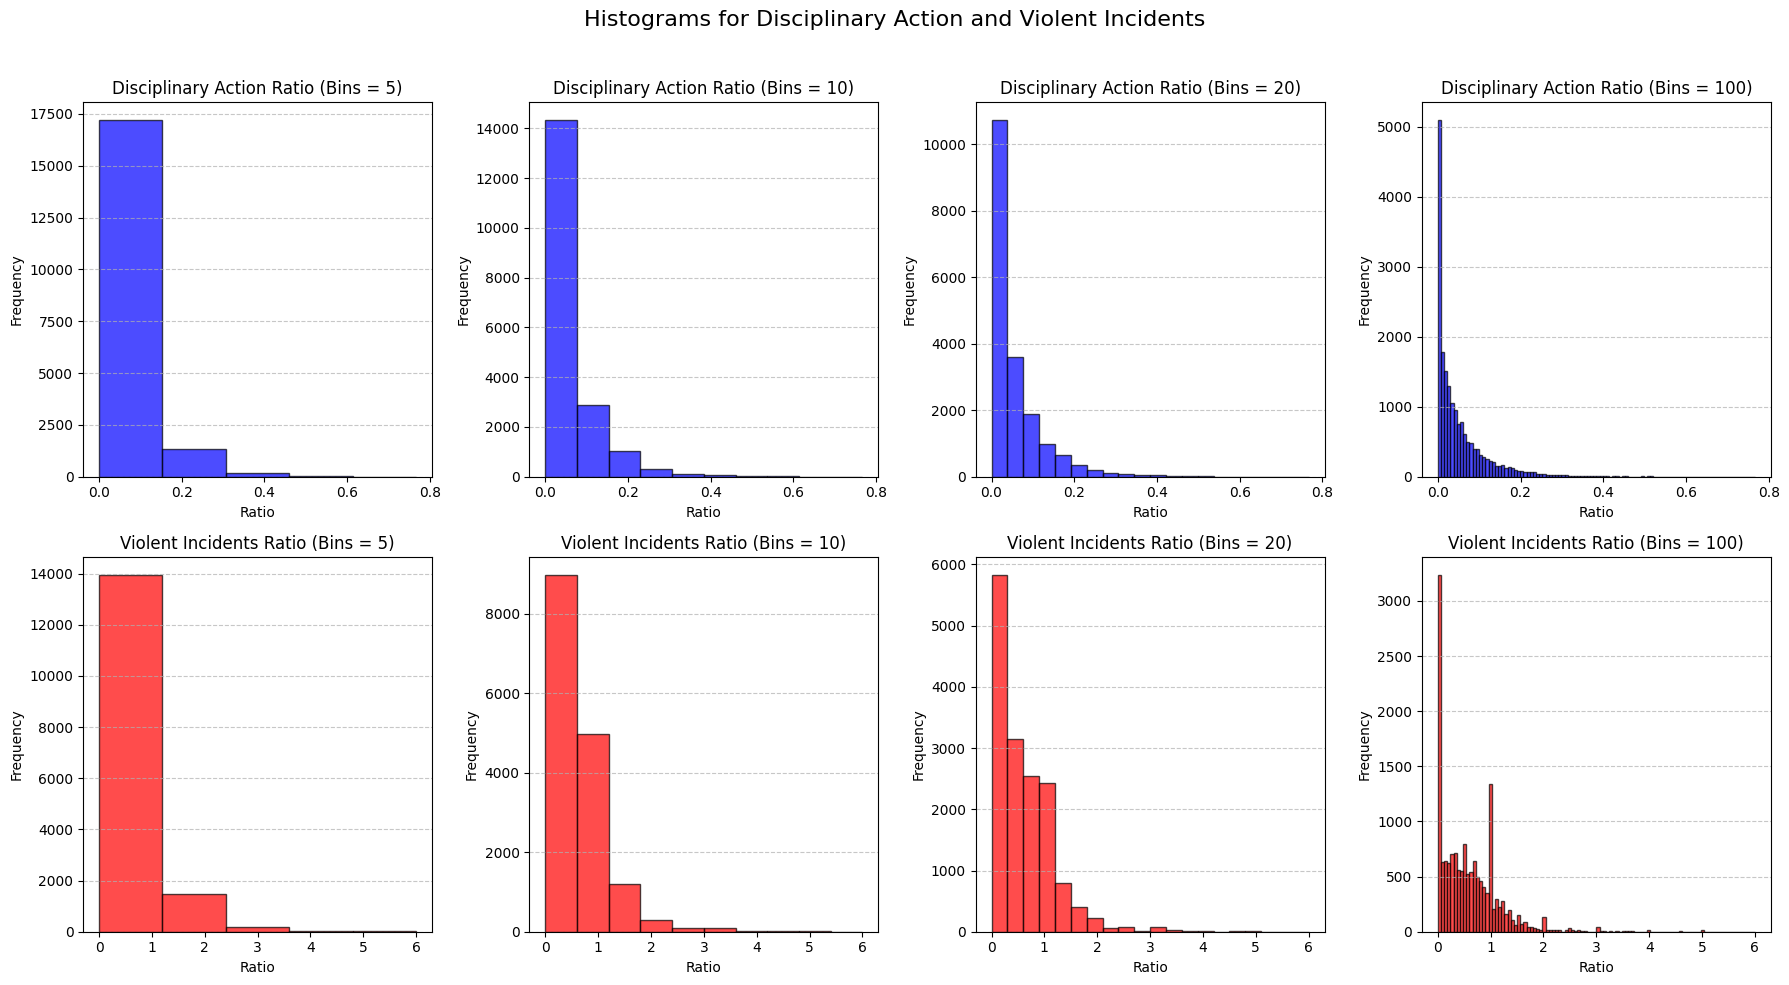

In [3]:
hf.generate_histograms(hf.report_card_df)

In [4]:
for column in hf.columns_to_score:

    hf.report_card_df = hf.normalize_scores(hf.report_card_df, column, bin_size=5)
    hf.report_card_df = hf.normalize_scores(hf.report_card_df, column, bin_size=10)
    hf.report_card_df = hf.normalize_scores(hf.report_card_df, column, bin_size=20)
    hf.report_card_df = hf.normalize_scores(hf.report_card_df, column, bin_size=100)
    
    hf.report_card_df = hf.custom_score(hf.report_card_df, column, hf.custom_bins_scores_5, bin_size=5)
    hf.report_card_df = hf.custom_score(hf.report_card_df, column, hf.custom_bins_scores_10, bin_size=10)
    
    hf.report_card_df = hf.quantile_scores(hf.report_card_df, column, bin_size=5)
    hf.report_card_df = hf.quantile_scores(hf.report_card_df, column, bin_size=10)

for column in hf.columns_to_score:
    print(f"\nDistribution Table for {column.replace('_', ' ').title()} (Bins=5):")
    display(hf.score_distribution_table(hf.report_card_df, column, bin_size=5))

    print(f"\nDistribution Table for {column.replace('_', ' ').title()} (Bins=10):")
    display(hf.score_distribution_table(hf.report_card_df, column, bin_size=10))

    print(f"\nDistribution Table for {column.replace('_', ' ').title()} (Bins=20):")
    display(hf.score_large_distribution_table(hf.report_card_df, column, bin_size=20))

    print(f"\nDistribution Table for {column.replace('_', ' ').title()} (Bins=100):")
    display(hf.score_large_distribution_table(hf.report_card_df, column, bin_size=100))


Distribution Table for Disciplinary Action Ratio (Bins=5):


Score Quantile                                  Normal                      \
           Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0     0     1476     15.4%     76.7%        20.5%      1     76.7%     76.7%   
1    20     2831      7.2%     15.4%        10.1%      8     63.5%     74.1%   
2    40     2773      4.0%      7.2%         5.5%     41     46.3%     60.0%   
3    60     2583      2.0%      4.0%         2.9%    179     30.7%     45.9%   
4    80     2283      0.6%      2.0%         1.3%   1266     15.3%     30.6%   
5   100      946      0.1%      0.6%         0.4%  11397      0.1%     15.3%   

               Custom                                   
  Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0        76.7%     35     50.4%     76.7%        54.0%  
1        67.7%    211     30.0%     49.6%        37.1%  
2        50.8%   2672     10.0%     30.0%        14.9%  
3        37.2%   6728      2.0%     10.0%         4.8%  
4        19.4%   2531      0.5%      2.0%         1.2%  
5         3.9%    715      0.1%      0.5%         0.3%


Distribution Table for Disciplinary Action Ratio (Bins=10):


Score Quantile                                  Normal                      \
            Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0      0      737     20.5%     76.7%        26.1%      1     76.7%     76.7%   
1     10     1467     12.1%     20.5%        15.4%      3     70.0%     74.1%   
2     20     1412      8.5%     12.1%        10.0%      5     63.5%     67.7%   
3     30     1403      6.2%      8.5%         7.2%     10     53.8%     60.0%   
4     40     1373      4.7%      6.2%         5.4%     31     46.3%     53.4%   
5     50     1331      3.4%      4.7%         4.0%     63     38.4%     45.9%   
6     60     1294      2.4%      3.4%         2.9%    116     30.7%     38.3%   
7     70     1255      1.6%      2.4%         2.0%    305     23.1%     30.6%   
8     80     1152      0.9%      1.6%         1.2%    961     15.3%     23.0%   
9     90     1021      0.4%      0.9%         0.6%   2598      7.7%     15.3%   
10   100      447      0.1%      0.4%         0.2%   8799      0.1%      7.7%   

                Custom                                   
   Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0         76.7%      6     67.7%     76.7%        71.2%  
1         72.3%     10     56.0%     63.9%        58.8%  
2         63.9%     39     45.2%     54.3%        49.6%  
3         57.3%    112     35.0%     45.0%        38.4%  
4         50.4%    252     25.0%     34.9%        28.5%  
5         41.0%   1140     15.0%     25.0%        18.3%  
6         34.2%   4517      5.0%     15.0%         8.1%  
7         25.8%   5190      1.0%      5.0%         2.7%  
8         18.0%    911      0.5%      1.0%         0.7%  
9         10.3%    478      0.3%      0.5%         0.4%  
10         2.8%    237      0.1%      0.2%         0.2%


Distribution Table for Disciplinary Action Ratio (Bins=20):


Score Normal                                  Log Normal            \
          Count Min Ratio Max Ratio Median Ratio      Count Min Ratio   
0      0      1     76.7%     76.7%        76.7%          1     76.7%   
1      5      1     74.1%     74.1%        74.1%          2     72.3%   
2     10      2     70.0%     72.3%        71.2%          3     67.7%   
3     15      2     67.7%     67.7%        67.7%          3     63.5%   
4     20      3     63.5%     63.9%        63.6%          4     58.2%   
5     25      5     57.6%     60.0%        58.3%          7     53.4%   
6     30      5     53.8%     57.1%        54.3%         21     49.1%   
7     35     16     50.4%     53.4%        51.2%         15     45.0%   
8     40     15     46.3%     49.6%        48.6%         31     40.7%   
9     45     23     42.3%     45.9%        43.5%         61     36.8%   
10    50     40     38.4%     41.9%        39.8%         37     32.9%   
11    55     56     34.6%     38.3%        37.1%         87     29.2%   
12    60     60     30.7%     34.3%        32.2%        121     25.6%   
13    65    112     26.9%     30.6%        28.8%        213     22.0%   
14    70    193     23.1%     26.8%        24.7%        343     18.6%   
15    75    345     19.2%     23.0%        20.8%        559     15.3%   
16    80    616     15.3%     19.1%        17.0%        711     12.1%   
17    85    906     11.5%     15.3%        13.1%       1237      8.9%   
18    90   1692      7.7%     11.5%         9.3%       1889      5.9%   
19    95   3169      3.8%      7.7%         5.5%       3043      2.9%   
20   100   5630      0.1%      3.8%         1.7%       4504      0.1%   

                           
   Max Ratio Median Ratio  
0      76.7%        76.7%  
1      74.1%        73.2%  
2      70.0%        67.7%  
3      63.9%        63.6%  
4      60.0%        58.8%  
5      57.6%        54.3%  
6      53.1%        50.7%  
7      48.9%        46.7%  
8      44.8%        42.3%  
9      40.7%        38.1%  
10     36.6%        35.0%  
11     32.8%        30.7%  
12     29.1%        27.2%  
13     25.5%        23.4%  
14     22.0%        20.2%  
15     18.6%        16.8%  
16     15.3%        13.5%  
17     12.1%        10.2%  
18      8.9%         7.1%  
19      5.9%         4.2%  
20      2.9%         1.4%


Distribution Table for Disciplinary Action Ratio (Bins=100):


Score Normal                                  Log Normal            \
           Count Min Ratio Max Ratio Median Ratio      Count Min Ratio   
0       0      1     76.7%     76.7%        76.7%          1     76.7%   
1       1      0       N/A       N/A          N/A          0       N/A   
2       2      0       N/A       N/A          N/A          0       N/A   
3       3      0       N/A       N/A          N/A          1     74.1%   
4       4      1     74.1%     74.1%        74.1%          0       N/A   
..    ...    ...       ...       ...          ...        ...       ...   
96     96    887      3.1%      3.8%         3.4%        804      2.3%   
97     97   1047      2.3%      3.1%         2.7%        895      1.7%   
98     98   1192      1.5%      2.3%         1.9%        906      1.1%   
99     99   1298      0.8%      1.5%         1.1%       1070      0.6%   
100   100   1206      0.1%      0.8%         0.5%        829      0.1%   

                            
    Max Ratio Median Ratio  
0       76.7%        76.7%  
1         N/A          N/A  
2         N/A          N/A  
3       74.1%        74.1%  
4         N/A          N/A  
..        ...          ...  
96       2.9%         2.6%  
97       2.3%         2.0%  
98       1.7%         1.4%  
99       1.1%         0.9%  
100      0.6%         0.3%  

[101 rows x 9 columns]


Distribution Table for Violent Incidents Ratio (Bins=5):


Score Quantile                                  Normal                      \
           Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0     0     1284    131.8%    600.0%       166.7%      2    600.0%    600.0%   
1    20     2582     94.2%    131.6%       100.0%     12    500.0%    500.0%   
2    40     2574     61.7%     94.1%        75.0%     30    360.0%    464.7%   
3    60     2583     36.6%     61.5%        50.0%    188    240.0%    358.8%   
4    80     2563     13.4%     36.6%        25.0%   1480    120.0%    237.5%   
5   100     1306      0.3%     13.3%         7.4%  11180      0.3%    119.8%   

               Custom                                   
  Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0       600.0%     96    300.8%    600.0%       356.7%  
1       500.0%    714    150.3%    300.0%       193.3%  
2       399.0%   1654    100.7%    150.0%       120.4%  
3       279.5%   4939     50.2%    100.0%        78.8%  
4       143.9%   2900     25.2%     50.0%        38.5%  
5        52.6%   2589      0.3%     25.0%        13.3%


Distribution Table for Violent Incidents Ratio (Bins=10):


Score Quantile                                  Normal                      \
            Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0      0      616    167.0%    600.0%       200.0%      2    600.0%    600.0%   
1     10     1280    114.4%    166.7%       133.3%      0       N/A       N/A   
2     20      568    100.7%    114.3%       109.1%     12    500.0%    500.0%   
3     30     2048     84.4%    100.0%       100.0%      6    456.2%    464.7%   
4     40     1285     67.7%     84.4%        75.0%     24    360.0%    400.0%   
5     50     1259     55.7%     67.6%        61.9%     92    300.0%    358.8%   
6     60     1324     43.6%     55.6%        50.0%     96    240.0%    280.0%   
7     70     1289     31.3%     43.5%        36.6%    284    180.0%    237.5%   
8     80     1196     20.2%     31.2%        25.9%   1196    120.0%    178.9%   
9     90     1379      7.4%     20.0%        14.0%   4970     60.0%    119.8%   
10   100      648      0.3%      7.3%         4.5%   6210      0.3%     59.8%   

                Custom                                   
   Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0        600.0%     96    300.8%    600.0%       356.7%  
1           N/A    714    150.3%    300.0%       193.3%  
2        500.0%    636    125.2%    150.0%       135.7%  
3        460.0%   1018    100.7%    125.0%       113.3%  
4        385.8%   2686     75.0%    100.0%        95.4%  
5        305.4%   1192     62.6%     75.0%        68.9%  
6        253.5%   1061     50.2%     62.5%        57.1%  
7        200.0%   1516     37.6%     50.0%        45.9%  
8        136.9%   1384     25.2%     37.5%        31.8%  
9         88.9%   1347     12.6%     25.0%        20.0%  
10        30.0%   1242      0.3%     12.5%         7.1%


Distribution Table for Violent Incidents Ratio (Bins=20):


Score Normal                                  Log Normal            \
          Count Min Ratio Max Ratio Median Ratio      Count Min Ratio   
0      0      2    600.0%    600.0%       600.0%          2    600.0%   
1      5      0       N/A       N/A          N/A          0       N/A   
2     10      0       N/A       N/A          N/A         12    500.0%   
3     15      0       N/A       N/A          N/A          6    456.2%   
4     20     12    500.0%    500.0%       500.0%         12    397.6%   
5     25      6    456.2%    464.7%       460.0%         34    333.3%   
6     30      0       N/A       N/A          N/A         70    300.0%   
7     35     12    397.6%    400.0%       400.0%         48    254.5%   
8     40     12    360.0%    374.1%       366.7%         76    222.0%   
9     45     22    333.3%    358.8%       350.0%        200    191.7%   
10    50     70    300.0%    328.6%       300.0%        206    164.7%   
11    55     16    273.3%    280.0%       276.1%        362    140.4%   
12    60     80    240.0%    269.2%       250.0%        746    117.9%   
13    65     56    210.7%    237.5%       221.3%       1956     97.7%   
14    70    228    180.0%    208.8%       200.0%       1178     79.3%   
15    75    398    150.0%    178.9%       160.0%       1428     62.8%   
16    80    798    120.0%    148.5%       130.8%       1692     47.6%   
17    85   2422     90.0%    119.8%       100.0%       1231     33.9%   
18    90   2548     60.0%     89.9%        73.3%       1500     21.5%   
19    95   3143     30.0%     59.8%        45.0%       1177     10.2%   
20   100   3067      0.3%     30.0%        15.7%        956      0.3%   

                           
   Max Ratio Median Ratio  
0     600.0%       600.0%  
1        N/A          N/A  
2     500.0%       500.0%  
3     464.7%       460.0%  
4     400.0%       400.0%  
5     374.1%       355.1%  
6     328.6%       300.0%  
7     280.0%       266.7%  
8     252.4%       242.5%  
9     220.7%       200.0%  
10    190.5%       173.5%  
11    164.4%       150.0%  
12    140.0%       127.3%  
13    117.6%       100.0%  
14     97.6%        87.5%  
15     79.2%        70.6%  
16     62.7%        54.3%  
17     47.5%        40.5%  
18     33.9%        28.6%  
19     21.4%        15.8%  
20     10.2%         6.0%


Distribution Table for Violent Incidents Ratio (Bins=100):


Score Normal                                  Log Normal            \
           Count Min Ratio Max Ratio Median Ratio      Count Min Ratio   
0       0      2    600.0%    600.0%       600.0%          2    600.0%   
1       1      0       N/A       N/A          N/A          0       N/A   
2       2      0       N/A       N/A          N/A          0       N/A   
3       3      0       N/A       N/A          N/A          0       N/A   
4       4      0       N/A       N/A          N/A          0       N/A   
..    ...    ...       ...       ...          ...        ...       ...   
96     96    702     24.0%     30.0%        27.0%        242      8.1%   
97     97    622     18.0%     24.0%        20.6%        232      6.0%   
98     98    637     12.0%     17.9%        14.3%        198      4.0%   
99     99    630      6.0%     11.9%         9.1%        188      2.0%   
100   100    476      0.3%      6.0%         3.3%         96      0.3%   

                            
    Max Ratio Median Ratio  
0      600.0%       600.0%  
1         N/A          N/A  
2         N/A          N/A  
3         N/A          N/A  
4         N/A          N/A  
..        ...          ...  
96      10.2%         9.2%  
97       8.1%         7.1%  
98       6.0%         5.3%  
99       3.9%         2.9%  
100      2.0%         1.2%  

[101 rows x 9 columns]

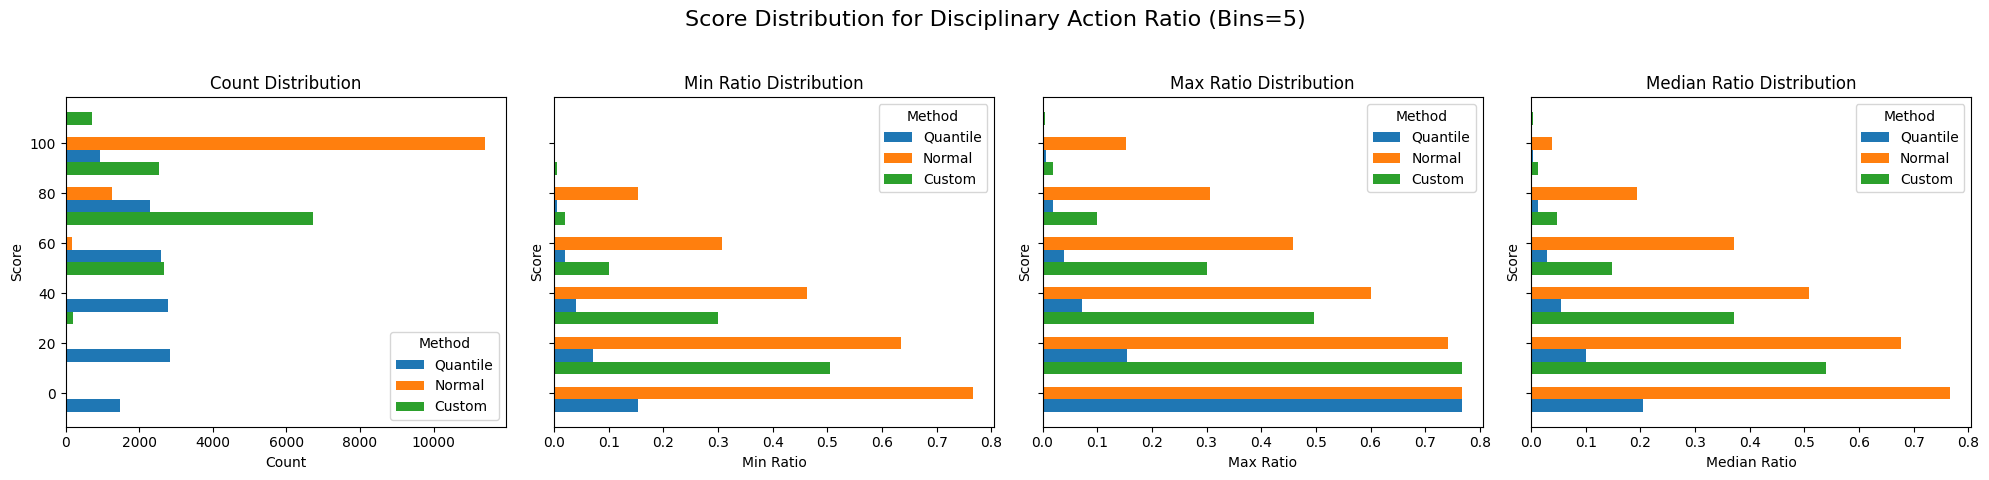

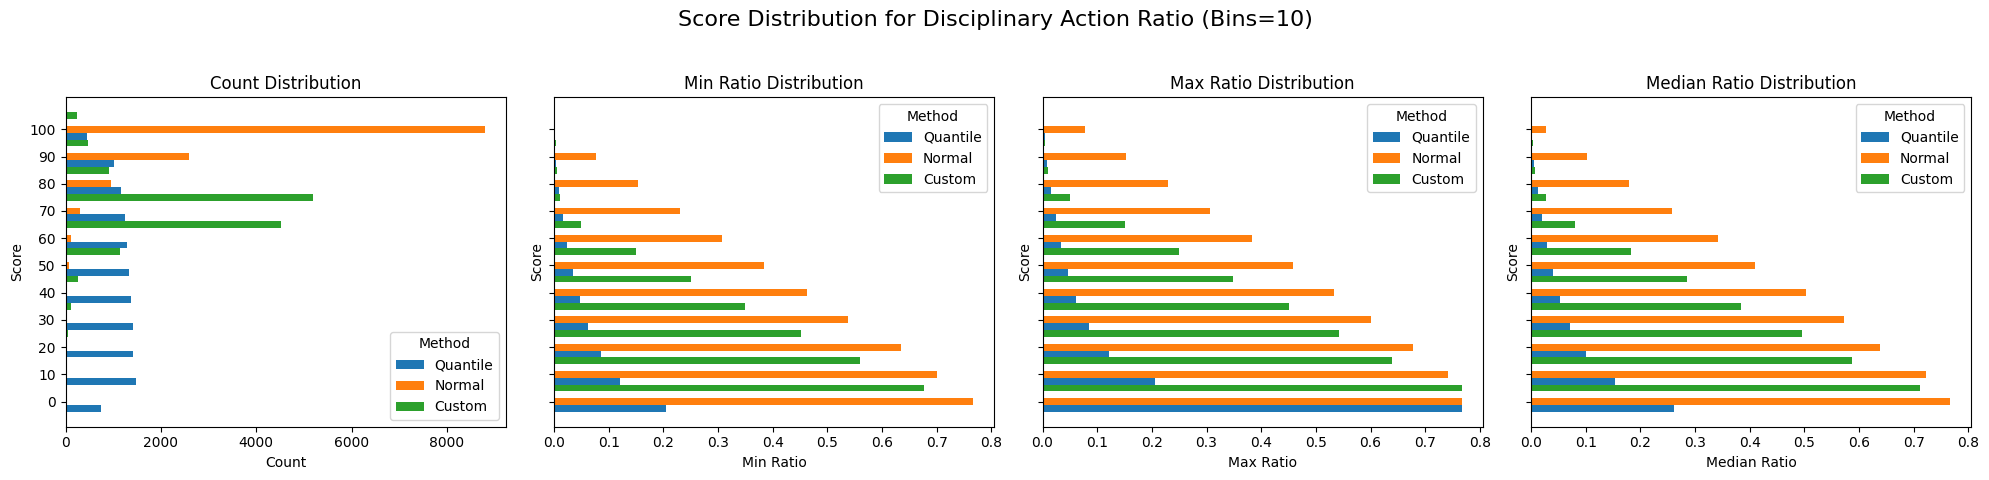

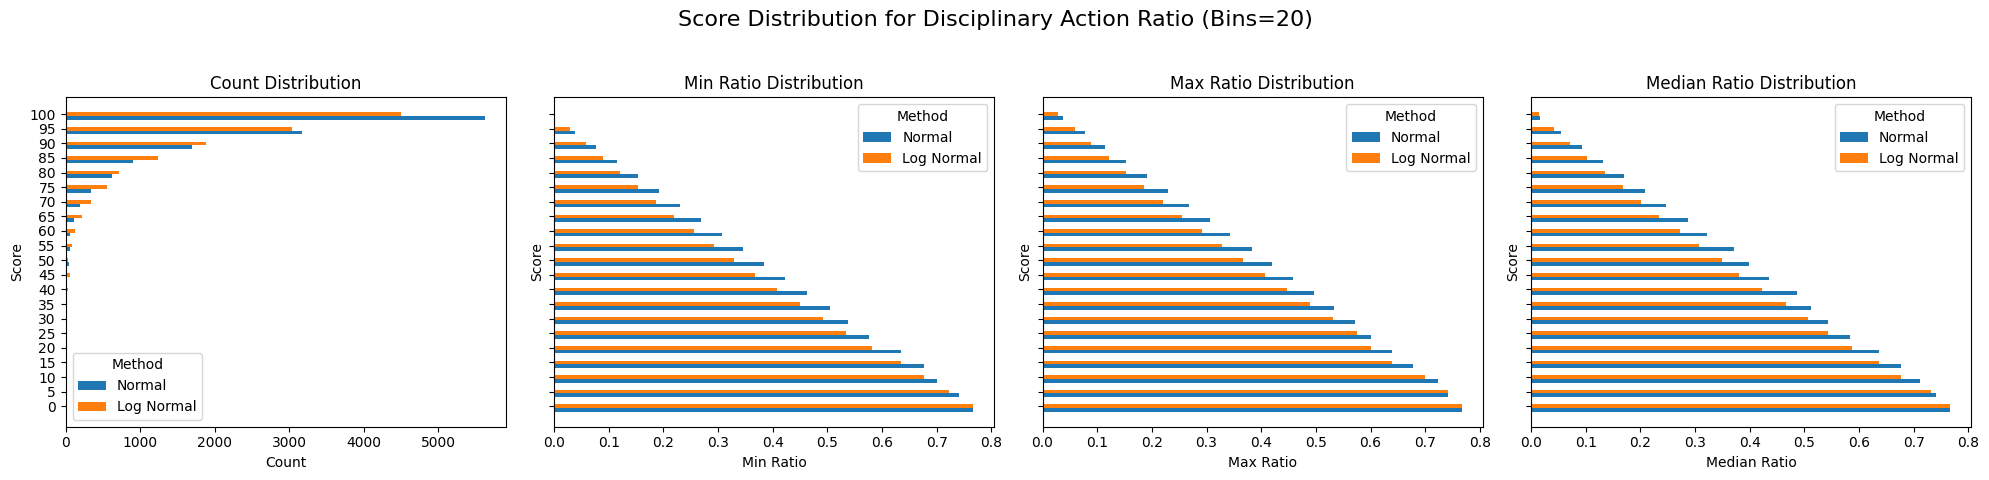

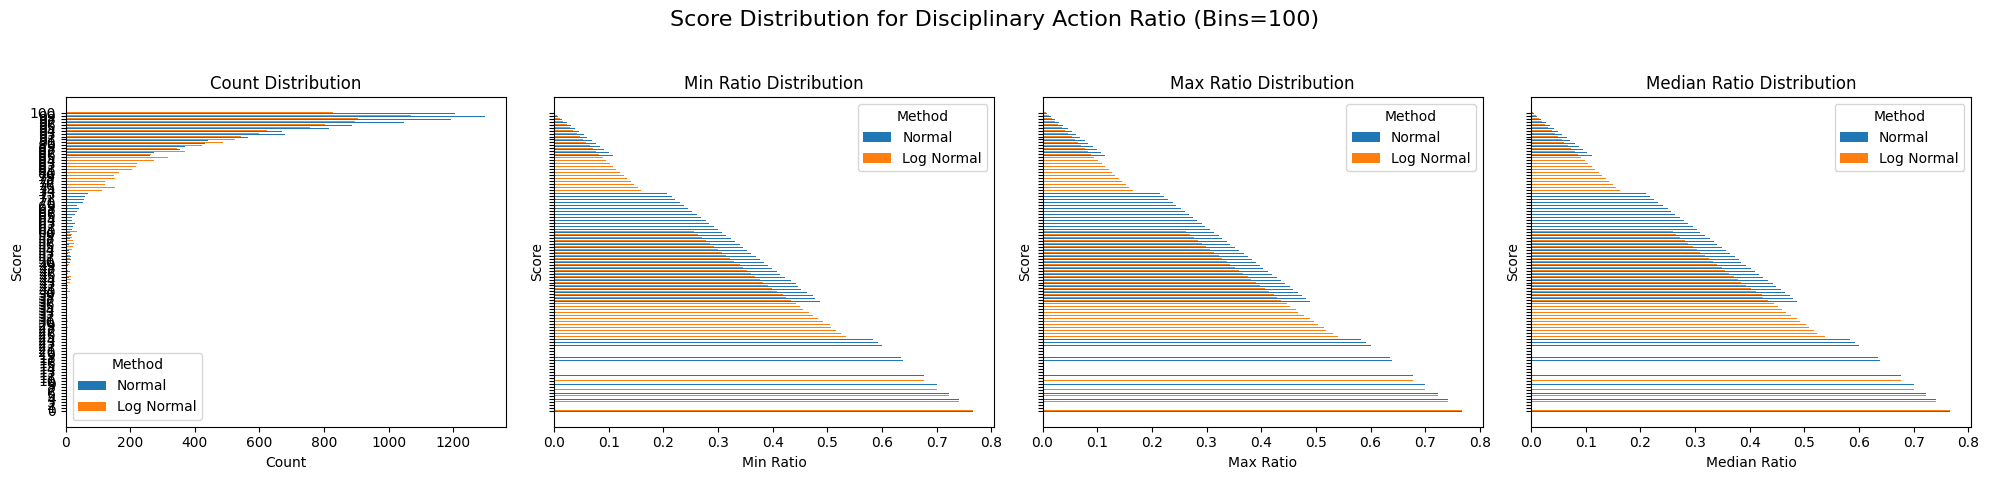

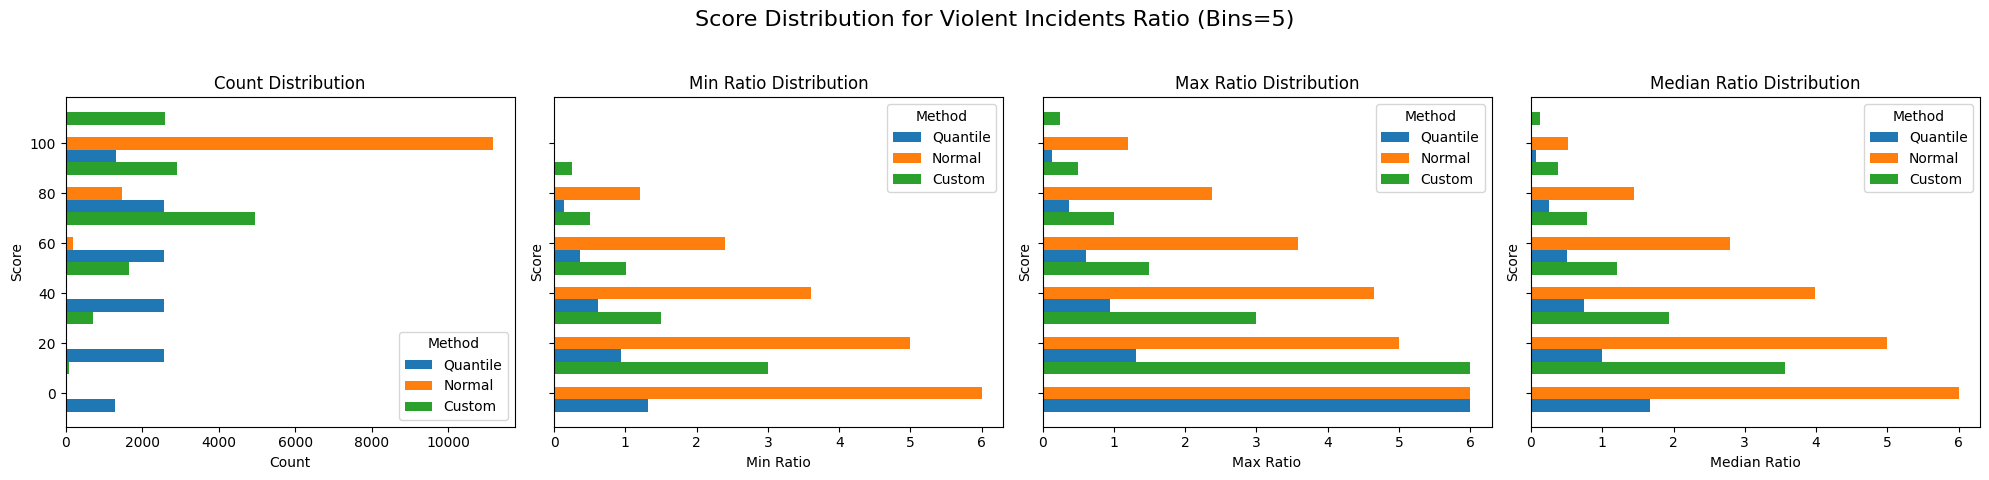

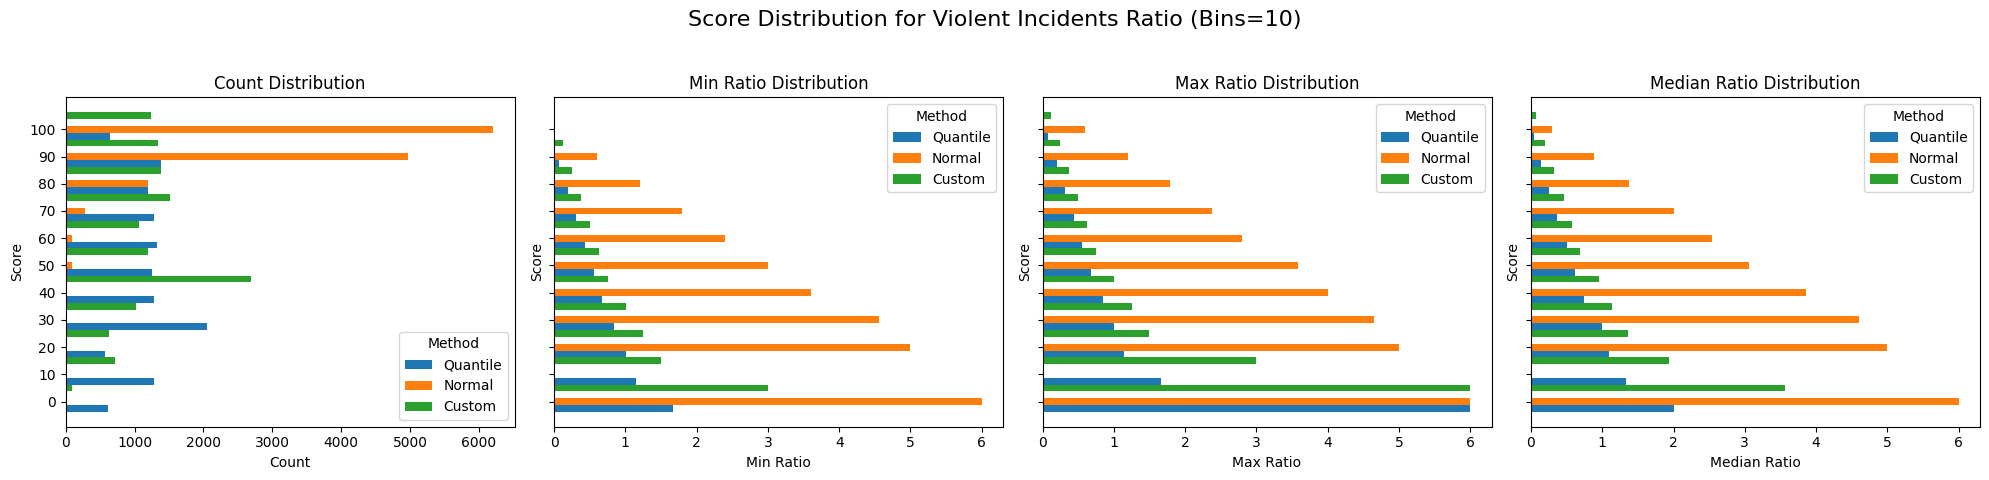

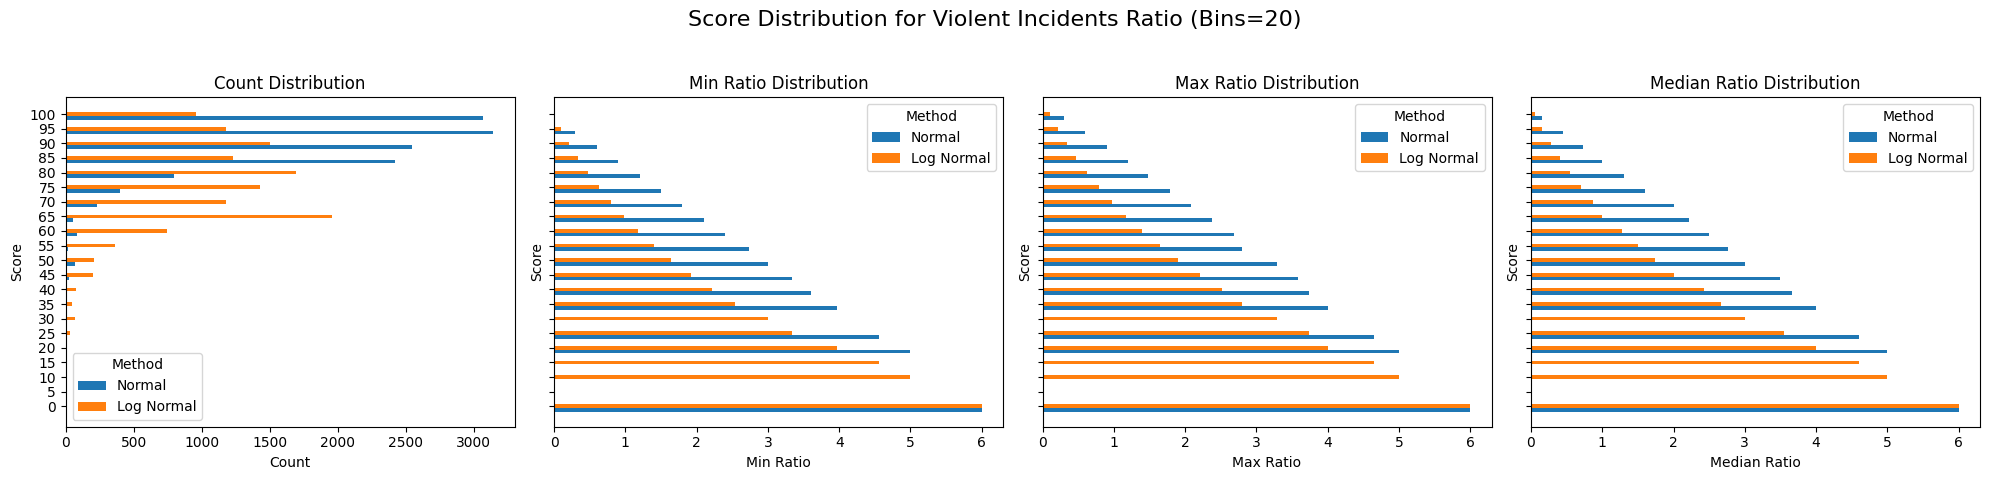

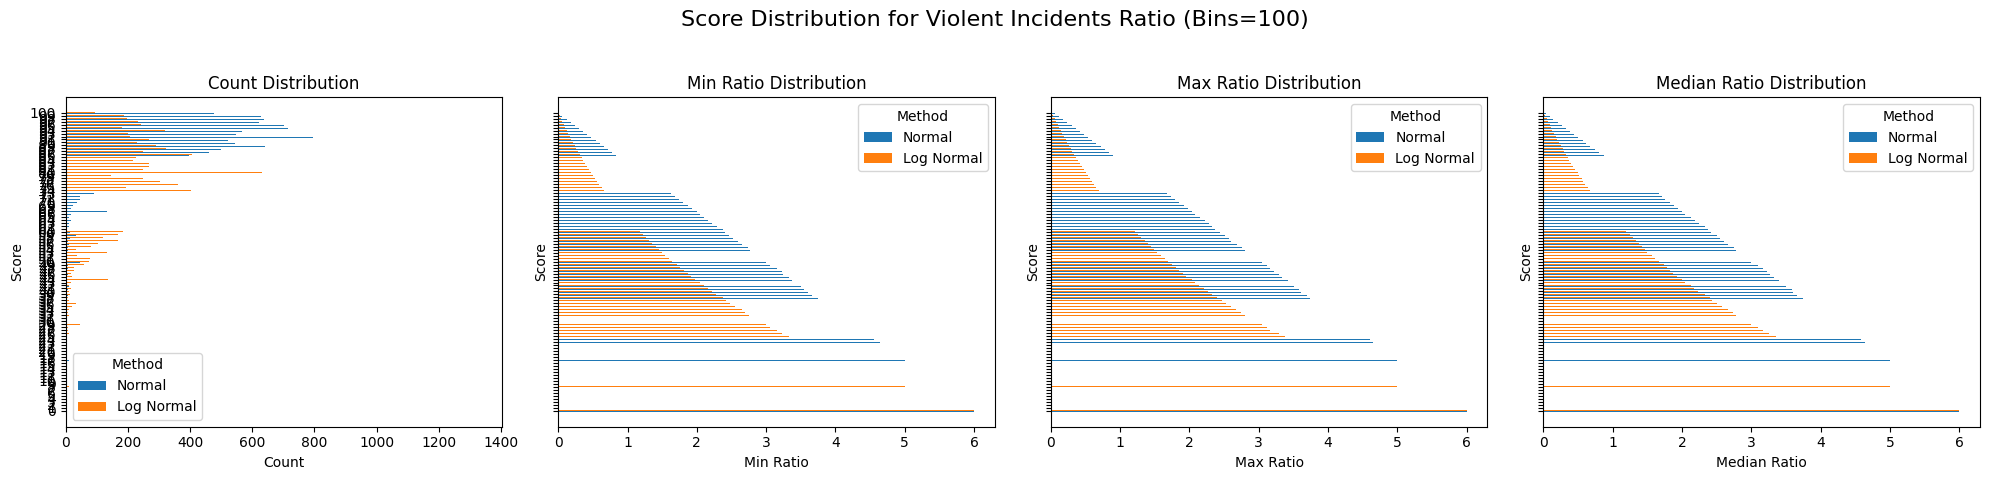

In [5]:
for column in hf.columns_to_score:
    hf.plot_score_distribution(hf.report_card_df, column, bin_size=5, methods=["Quantile", "Normal", "Log Normal", "Custom"])
    hf.plot_score_distribution(hf.report_card_df, column, bin_size=10, methods=["Quantile", "Normal", "Log Normal", "Custom"])
    hf.plot_score_distribution(hf.report_card_df, column, bin_size=20, methods=["Normal", "Log Normal"])
    hf.plot_score_distribution(hf.report_card_df, column, bin_size=100, methods=["Normal", "Log Normal"])


### Scoring Findings

When scoring schools based on various performance or metric data, four primary methods were used: **Quantiles**, **Normalization**, **Log-Normal Calculations**, and **Custom Scores**. Each method has its own advantages and challenges, depending on the objectives of the analysis and the desired distribution of scores. Below is a detailed comparison of these methods, including their characteristics, benefits, and trade-offs.

---

#### 1. **Quantiles**
Quantiles divide the data into equal-sized bins, ensuring that each bin contains the same number of schools. This results in an **even distribution of schools across the score range**, ensuring that no score range is overrepresented or underrepresented. However, this method has specific drawbacks, particularly in the range between the **minimum and maximum scores**.

##### Key Characteristics:
- **Even Distribution**: Ensures that each score bin has the same number of schools, which prevents bias towards any particular score group.
- **Wide Min/Max Range**: Because quantiles rely on an even count across bins, the minimum and maximum scores can sometimes exhibit large disparities. This occurs if the data is **skewed** or has outliers, leading to wider gaps between extreme scores.
- **Skewed Data Impact**: In cases where data is not normally distributed, some bins may contain a broad range of raw values, distorting the spread of scores.

##### Conclusion:
Quantiles are useful when we want a **uniform distribution of schools across score bins**, but in this case lead to a **less meaningful interpretation of the extremes** because of the wide min/max ratios. This method is most effective when looking to avoid any score bin being overrepresented or underrepresented, but it may not provide the most intuitive understanding of school performance.

---

#### 2. **Normalization**
Normalization involves scaling the scores such that all schools are converted to a **standardized range** between 0 and 100. This can be particularly useful for ensuring **consistency** across schools, making comparisons simpler.

##### Key Characteristics:
- **Scaling to 100**: All schools are scaled to a score of 100, which helps to create a **unified benchmark** across all schools, regardless of their original ratio distributions.
- **Skewed High**: One of the significant downsides is that most schools will have scores that are clustered near the top (close to 100). This is particularly true if a large portion of schools perform similarly well.
- **Better Distribution for High Scores**: Although normalization results in most schools clustering around the high end of the scale, it **improves the distribution** of scores as they approach the maximum.

##### Conclusion:
Normalization is a **strong choice for consistency** and can provide a more balanced view of higher-performing schools. However, it lacks **variability at the lower end**, making it harder to distinguish schools with lower performance. If the goal is to focus on the **top-performing schools** or to maintain a consistent scoring approach, normalization works well. However, it sacrifices finer distinctions between schools.

---

#### 3. **Log-Normal Calculations**
Given the skewed nature of the data, we explored using **log-normal binning** instead of standard binning methods. This method adjusts for skewness by applying a logarithmic transformation, ensuring a more balanced distribution across score bins.

##### Key Characteristics:
- **Better Distribution**: Log-normal binning redistributes scores more evenly across the range, reducing the impact of skewed data.
- **Improved Granularity**: This method allows for finer distinctions between schools, particularly when using a higher number of bins.
- **Handles Skewed Data Effectively**: Unlike standard quantiles, which may result in large min/max disparities, log-normal calculations provide a more natural spread of scores.

##### Conclusion:
Log-normal binning is highly effective in handling **skewed distributions** and provides a more meaningful score distribution. **100 bins using a log-normal approach** is the most detailed option, while **20 bins using log-normal** offers a good balance between granularity and interpretability.

---

#### 4. **Custom Scores**
Custom scores involve creating **user-defined bins** for categorizing schools into score ranges. This method introduces **flexibility** into the process, allowing for a more **logical distribution** of scores, which can often reflect the underlying reality of the data more clearly.

##### Key Characteristics:
- **Logical Distribution**: By defining custom bins based on meaningful intervals or benchmarks, custom scores result in a distribution that is more intuitive and easier to interpret.
- **Arbitrary Binning**: One significant drawback of custom scores is the potential for **subjectivity** in how bins are created. The bins may not always align with statistical significance, leading to **arbitrary decisions** about where to draw the cutoffs.
- **Flexibility**: This method offers the flexibility to adapt scoring bins based on the specific needs of the analysis.

##### Conclusion:
Custom scores offer a **practical balance** between flexibility and interpretability. However, the **arbitrary nature** of binning may introduce challenges in ensuring consistency across datasets or in comparing scores across different periods.

---

### Binning Size: 5 vs. 10 vs. 20 vs. 100

The bin size plays a critical role in how the data is categorized and interpreted. We evaluated bin sizes of **5, 10, 20, and 100** to better handle skewed distributions.

#### Bin Size Comparisons:
- **5 Bins**: Provides a broad, high-level grouping of schools but lacks precision in distinguishing performance levels.
- **10 Bins**: Offers better granularity while still being interpretable, but struggles with skewed distributions.
- **20 Bins**: A significant improvement over 5 and 10 bins, providing more detailed score distinctions while remaining interpretable.
- **100 Bins**: Shows the most granular distribution of ratios by score, revealing finer distinctions between schools.

##### Conclusion:
- **100 bins using a log-normal approach** is significantly better than using 5 or 10 bins and somewhat better than using 20 bins.
- **20 bins using log-normal** is a good alternative for balancing granularity and interpretability.
- **Quantiles do not handle the skewed distribution well**, making them a poor choice.
- **Manually defining bins at 20 or 100** would be too complex, so using an automated log-normal approach is preferable.

---

### Summary of Trade-offs:

| Method         | Key Strengths                                    | Key Drawbacks                                  | Best Use Case                               |
|---------------|------------------------------------------------|-----------------------------------------------|---------------------------------------------|
| **Quantiles**  | - Even distribution of schools across bins       | - Poor handling of skewed data                 | Not recommended for skewed data            |
| **Normalization** | - Consistent scaling across schools          | - Limited differentiation at lower scores      | Useful for benchmarking top-performing schools |
| **Custom Scores** | - Logical and interpretable bins             | - Subjectivity in defining bins                | Best when interpretability is the top priority |
| **Log-Normal** | - Handles skewed data effectively               | - Can be difficult to interpret for non-technical users | Best for detailed insights with skewed data |

---

### Conclusion:
For scoring schools, **log-normal binning with 100 bins provides the best results**, as it accounts for skewed data while maintaining granularity. **20 bins using log-normal** is a good compromise for easier interpretation. Quantiles and smaller bin sizes (5 and 10) do not adequately capture the data's skewness, making them less suitable for this analysis.